# Exercise 1: t-SNE

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

316492776
318900016

---
---


In [ ]:
# Required dependencies
!pip3 install numpy scipy pandas scikit-learn matplotlib mpl-tools tqdm

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from tqdm.auto import tqdm

np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

tSNE is a non-linear dimensionality reduction algorithm, used mostly for the purpose of visualization in 2d and sometimes 3d.
Its input is $n$ points in a high dimentional space $\mathbb{R}^h$, and its output is $n$ correspoinding points in a $\mathbb{R}^2$.

The algorithm calculates pairwise similarity is the original space $p_{ij}$, and tries to make the similarities in the lower dimensional space $q_{ij}$ have the same distribution.
Its cost function is KL-divergence between P and Q distributions, which means higher $p_{ij}$ values are more important than smaller ones, meaning tSNE generally focuses on preserving local structure but will sometimes fail to capture global relationships.

tSNE is symetric (unlike regular SNE), and also uses t-distribution in the lower dimentional space in order to avoid shrinkage to a single point or a very dense cluster (since it has a heavy tail, unlike a gaussian which does not).

# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

We implement t-SNE as seen in the class, more specifically according to slides 61-66.
The calculation of $q_{ij}$ and $p_{ij}$ is pretty straight forward according to the theorey shown in class. We did, however, add one major improvement to make the algorithm converge in feasable time. Instead of calculating $p_{ij}$ for all $i \neq j$ pairs, we calculate it only for the $k$ closest neighbors (in the original space) of each point, since they contibute the most to the value of $C$, since if $X_i$ and $X_j$ are far apart, $p_{ij}$ will be closer to 0, and hence will not make much of a difference in the total summation of $C$.

Everything is done with vectorized code, to maximize efficiency and speed as much as possible.

By doing so, instead of calculating $N^2$ for each iteration for a total of $O(N^2 \cdot i)$ with $i$ being the number of iteration, we calculate only $O(N^2 + N \cdot k \cdot i)$, and with $p \ll N$ this makes a major difference.

The optimization is done by gradient descent process, with an option for early stopping if no progress is made after some time.

In [16]:
class CustomTSNE:
    def __init__(self, perplexity: float = 30.0, n_components: int = 2, n_iter: int = 1000, learning_rate: float = 200.0,
                 n_iter_without_progress: int = 3000, verbose: bool = True):
        self.perplexity = perplexity
        self.n_components = n_components
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        # Note: You may add more attributes
        self.sigma = 1  # TODO
        self.n_iter_without_progress = n_iter_without_progress
        self.verbose = verbose
        self.min_iter = n_iter // 10

    def fit_transform(self, X):
        # Part 1: Implementing t-SNE

        # Step 1: Compute pairwise affinities in the original space with a Gaussian distribution
        # Your code here
        X = X/np.max(X)
        N = len(X)
        n_neighbors = min(N-1, 3*int(self.perplexity))
        X_dists = squareform(pdist(X))
        n_nearest_indexes = np.argsort(X_dists, axis=1)[:, 1:n_neighbors+1]
        # +1 to remove i=j
        X_dists = np.take_along_axis(X_dists, n_nearest_indexes, axis=1)
        p_ij = self.calc_pij(X_dists)

        Y = np.random.random((N, self.n_components))

        best_i, best_C = -1, np.inf
        for i in tqdm(range(self.n_iter), disable=not self.verbose, desc="iteration"):
            Y_diff = Y[:, np.newaxis, :] - Y[n_nearest_indexes]
            Y_dists = np.linalg.norm(Y_diff, axis=-1)
            Y_dists = 1+Y_dists**2
            Y_dists = Y_dists ** -1
            q_ij = Y_dists / np.sum(Y_dists)  # normalize to a probabilty

            C = p_ij * np.log(p_ij/q_ij)
            C = np.sum(C)
            if self.verbose:
                print(f"After {i} iterations, {C=}")
            if C < best_C:
                best_i, best_C = i, C
            if self.min_iter < i and best_i + self.n_iter_without_progress < i:
                if self.verbose:
                    print(
                        f"C has not improved for {self.n_iter_without_progress} steps. Stopping early.")
                return Y

            grad_C_yi = 4 * \
                np.sum((p_ij - q_ij)[..., np.newaxis] *
                       Y_diff * Y_dists[..., np.newaxis], axis=1)

            # Return Y, the 2D representation of the input data
            Y -= self.learning_rate * grad_C_yi
        if self.verbose:
            print(f"{C=} after {self.n_iter} iterations")
        return Y

    # Part 2: Transformation of New Data Points
    def transform(self, X_original, Y_original, X_new):
        N = len(X_new)
        n_neighbors = min(N-1, 3*int(self.perplexity))
        Y_new = []

        # Added weights to the distances as following: [1, 1/2, 1/3, 1/4.... 1/n]
        # The minimal distance get's the highest weight, and the weight is reduced as the distance increasing
        W_arr = np.arange(1, n_neighbors + 1, dtype=float) ** -1

        dists = cdist(X_new, X_original)
        n_nearest_indexes = np.argsort(dists, axis=1)[:, :n_neighbors]
        Y_new = np.average(
            Y_original[n_nearest_indexes], weights=W_arr, axis=1)

        # for i in range(X_new.shape[0]):
        #     # Calculate the distance array for each one of the test values
        #     d = cdist(X_new[i].reshape(1, -1), X_original)

        #     # Sort the indices of the distances from minimal to maximal while limit just to the n_neighbors distances
        #     d_argsort = np.argsort(d, axis=1).flatten()[:n_neighbors]

        #     # Find the average location based on the indices of the distances, while the distances are weighted (Minimal distance -> max weight)
        #     dest_value = np.average(Y_original[d_argsort], axis=0, weights=W_arr)

        #     Y_new.append(dest_value)

        return np.array(Y_new)

    def calc_pij(self, X_dists, min_sigma: float = 1e-3, max_sigma: float = 1e+3):
        N = len(X_dists)
        min_sigma = np.ones((N, 1))*min_sigma
        max_sigma = np.ones((N, 1))*max_sigma
        for i in tqdm(range(30), disable=not self.verbose, desc="finding sigma"):
            curr_sigma = (min_sigma + max_sigma)/2
            p_ij = -X_dists**2 / (2*curr_sigma**2)
            # for numeric stability
            p_ij -= p_ij.max(axis=1, keepdims=True)
            p_ij = np.exp(p_ij)
            # normalize to a probabilty
            p_ij = p_ij / p_ij.sum(axis=1, keepdims=True)
            distribution_entropy = (-p_ij * np.log2(p_ij)
                                    ).sum(axis=1, keepdims=True)
            distribution_perplexity = 2**distribution_entropy
            min_sigma, max_sigma = (
                np.where(distribution_perplexity <
                         self.perplexity, curr_sigma, min_sigma),
                np.where(distribution_perplexity >
                         self.perplexity, curr_sigma, max_sigma)
            )

        return p_ij / p_ij.sum()

# Load data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

We chose to use MNIST dataset to our algorithm.
MNIST is a very popular yet simple dataset, which is used wordlwide for basic/begginer ML tasks, and has many examples specifically for dimensionality reduction outputs (PCA and tSNE). This will allow us to compare ourself. 
It's usage is about encoding a digit in an image (Assuming the digit is shown as pixels just like one takes a photo of a car plate), and each image is labeled by it's digit value

Using T-SNE algorithm, we can find the relationship and the distances between the images with a very clear and visual way, while since we have just 10 digits in MNIST (0-9), we can classify the images into 10 groups and show in 2D dimension the relationship and distance between them

We split the dataset into train (80%) and test (20%) while the dataset contains 10,000 examples in total

Since the image values are described by RGB codes (0 -> white to 255 -> black), the digits should be represented as black while the background as white, but in fact the digits are in various range of colors between white and black (gray, dark gray. etc). Then, in order to reduce errors since the colors distribution, we want to normalize it so the digit will be represented with one single RGB code

In [7]:
# Loading the data into train / test datasets

dataset = pd.read_csv("./Dataset/mnist_dataset.csv")

# The X axis is the pixels RGB matrix that represents the digit
X = dataset.loc[:,'1x1':].values

# The y axis is the actual digit that the the pixels matrix represents
y = dataset.loc[:,'label'].values

X_train, X_test, label_train, label_test = train_test_split(
    X, y, test_size=0.2)

# Normalizing the RGB codes by dividing it to the max RGB value.
X_train_normalized_opt1 = X_train / 255
X_test_normalized_opt1 = X_test / 255

# Normalizing the RGB codes by standard scaler
sc = StandardScaler()
X_train_normalized_opt2 = sc.fit_transform(X_train)
X_test_normalized_opt2 = sc.transform(X_test)

In [8]:
dataset.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X_train.shape

(8000, 784)

In [10]:
X_train_normalized_opt1.shape

(8000, 784)

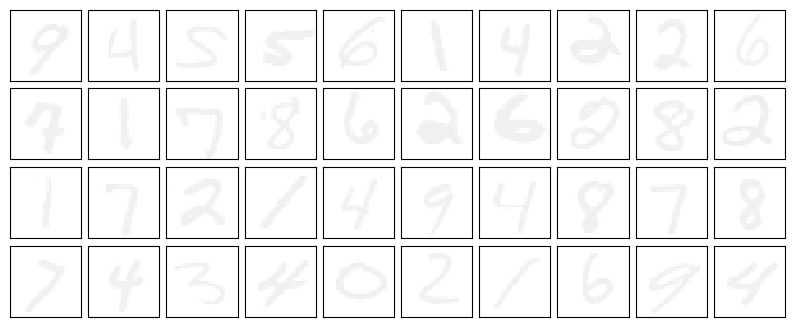

In [11]:
# This is a ploting of sample train data

fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_normalized_opt1[i].reshape(28, 28),
              cmap='binary', interpolation='nearest',
              clim=(0, 16))

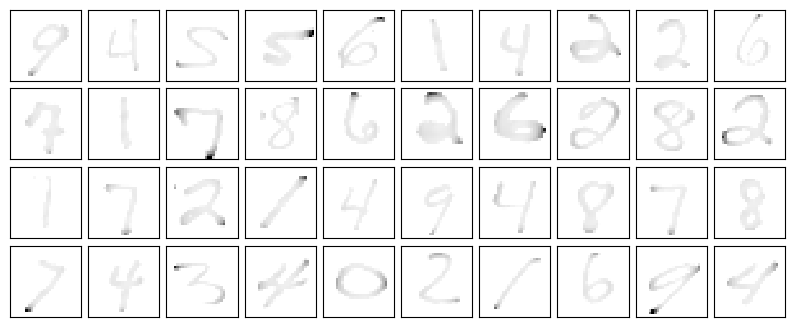

In [12]:
# This is a ploting of sample train data

fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_normalized_opt2[i].reshape(28, 28),
              cmap='binary', interpolation='nearest',
              clim=(0, 16))

# t-SNE demonstration 
Demonstrate your t-SNE implementation.

Add plots and figures. The code below is just to help you get started, and should not be your final submission.

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

As we can see below, we've tested the module with a various combination of Hypher-Parameters

The most important hypher-param is the perplexity. We found that a large number of perplexity causes a very dense and unified groups of digits but with some little mistakes since with high perplexity we can also "catch" neighbors that represents another disits. However, with a low number of perplexity the observabilities will not be unified and scattered along the graph
Therefore, according to our research the optimal perplexity number is something about 15-30

Regarding learning rate, higher learning rate causes the group be closer to each other, and smaller learning rate makes the groups be more far away, since the Y output values are getting more centralized with higher learning rate value. The optimal learning rate is about 100-200. However, it has less affect on the results than the perplexity

Redarding the number of iterations, we've tested with 1000 and 500 iterations and didn't find meaningful changes. However a large number of iterations can cause overfitting


In [17]:
hypher_pharams_options = [{
    'n_components': 2,
    'n_iter': 1000,
    'perplexity': 100,
    'learning_rate': 200
},{
    'n_components': 2,
    'n_iter': 1000,
    'perplexity': 50,
    'learning_rate': 200
},{
    'n_components': 2,
    'n_iter': 500,
    'perplexity': 30,
    'learning_rate': 100
},{
    'n_components': 2,
    'n_iter': 1000,
    'perplexity': 15,
    'learning_rate': 100
},{
    'n_components': 2,
    'n_iter': 1000,
    'perplexity': 15,
    'learning_rate': 50
},
{
    'n_components': 2,
    'n_iter': 1000,
    'perplexity': 5,
    'learning_rate': 50
},
{
    'n_components': 2,
    'n_iter': 1000,
    'perplexity': 50,
    'learning_rate': 200
},{
    'n_components': 3,
    'n_iter': 1000,
    'perplexity': 20,
    'learning_rate': 200
}]

results_array = []

for hypher_params in hypher_pharams_options:
    n_components = hypher_params["n_components"]
    n_iter = hypher_params["n_iter"]
    perplexity = hypher_params["perplexity"]
    learning_rate = hypher_params["learning_rate"]
    print(f"Running with number of components {n_components}, number of iterations {n_iter}, perplexity {perplexity} and lr {learning_rate}")
    
    # Run your custom t-SNE implementation
    custom_tsne = CustomTSNE(n_components=n_components, n_iter=n_iter, perplexity=perplexity, learning_rate=learning_rate)
    custom_Y = custom_tsne.fit_transform(X_train_normalized_opt1)
    
    # Run sklearn t-SNE
    sk_tsne = TSNE(n_components=n_components, init='random', perplexity=perplexity)
    sk_Y = sk_tsne.fit_transform(X_train_normalized_opt1)
    results_array.append({'custom_Y': custom_Y, 'sk_Y': sk_Y})

finding sigma:   0%|          | 0/30 [00:00<?, ?it/s]

iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

After 0 iterations, C=1.1163846195133627
After 1 iterations, C=1.1123612241006136
After 2 iterations, C=1.1084068625447163
After 3 iterations, C=1.1045188941390454
After 4 iterations, C=1.1006945012948055
After 5 iterations, C=1.0969307140457967
After 6 iterations, C=1.09322443538697
After 7 iterations, C=1.0895724671795253
After 8 iterations, C=1.0859715363866982
After 9 iterations, C=1.0824183214824943
After 10 iterations, C=1.0789094789781106
After 11 iterations, C=1.0754416700975982
After 12 iterations, C=1.0720115876644007
After 13 iterations, C=1.068615983211441
After 14 iterations, C=1.0652516942049446
After 15 iterations, C=1.0619156711069206
After 16 iterations, C=1.0586050038354233
After 17 iterations, C=1.0553169470541603


After 18 iterations, C=1.052048943658484
After 19 iterations, C=1.0487986458308893
After 20 iterations, C=1.045563933108772
After 21 iterations, C=1.0423429270231683
After 22 iterations, C=1.0391340020068975
After 23 iterations, C=1.0359357924109605
After 24 iterations, C=1.0327471955894632
After 25 iterations, C=1.0295673711046185
After 26 iterations, C=1.0263957361641045
After 27 iterations, C=1.0232319574444118
After 28 iterations, C=1.020075939494024
After 29 iterations, C=1.016927809966985
After 30 iterations, C=1.0137879020191372
After 31 iterations, C=1.0106567343002661
After 32 iterations, C=1.0075349890763292
After 33 iterations, C=1.0044234890921313
After 34 iterations, C=1.0013231738160289
After 35 iterations, C=0.9982350756872096
After 36 iterations, C=0.9951602969198383
After 37 iterations, C=0.9920999873238049
After 38 iterations, C=0.9890553234972859
After 39 iterations, C=0.9860274896460071
After 40 iterations, C=0.9830176601957937
After 41 iterations, C=0.9800269842931

In [ ]:
for idx, result in enumerate(results_array):
    if result["sk_Y"].shape[1] == 2:
        # Visualization of the result
        plt.figure()
        plt.scatter(result["custom_Y"][:, 0], result["custom_Y"][:, 1], s=5, c=label_train.astype(int), cmap='tab10')
        plt.colorbar()
        plt.title(f"MNIST Data Embedded into 2D with Custom t-SNE with {hypher_pharams_options[idx]['n_iter']} iterations, perplexity {hypher_pharams_options[idx]['perplexity']} and lr {hypher_pharams_options[idx]['learning_rate']}")
        plt.show()
        
        plt.figure()
        plt.scatter(result["sk_Y"][:, 0], result["sk_Y"][:, 1], s=5, c=label_train.astype(int), cmap='tab10')
        plt.colorbar()
        plt.title(f"MNIST Data Embedded into 2D with Sklearn t-SNE with {hypher_pharams_options[idx]['n_iter']} iterations, perplexity {hypher_pharams_options[idx]['perplexity']} and lr {hypher_pharams_options[idx]['learning_rate']}")
        plt.show()
        plt.show()
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(result["custom_Y"][:, 0], result["custom_Y"][:, 1], result["custom_Y"][:, 2], s= 5, c=label_train, cmap='tab10')
        plt.title(f"MNIST Data Embedded into 3D with Custom t-SNE with {hypher_pharams_options[idx]['n_iter']} iterations, perplexity {hypher_pharams_options[idx]['perplexity']} and lr {hypher_pharams_options[idx]['learning_rate']}")
        plt.show()
        plt.show()
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(result["sk_Y"][:, 0], result["sk_Y"][:, 1], result["sk_Y"][:, 2], s= 5, c=label_train, cmap='tab10')
        plt.title(f"MNIST Data Embedded into 3D with Sklearn t-SNE with {hypher_pharams_options[idx]['n_iter']} iterations, perplexity {hypher_pharams_options[idx]['perplexity']} and lr {hypher_pharams_options[idx]['learning_rate']}")
        plt.show()
        plt.show()

In [4]:
# Run sklearn t-SNE
sk_tsne_3d = TSNE(n_components=3, init='random', perplexity=N/10)
sk_Y_3d = sk_tsne_3d.fit_transform(X_train_normalized_opt2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(sk_Y_3d[:, 0], sk_Y_3d[:, 1],sk_Y_3d[:,2], s= 5, c=label_train, cmap='Spectral')
plt.title('Visualizing Kannada MNIST through t-SNE in 3D', fontsize=24);
plt.show()

NameError: name 'TSNE' is not defined

# t-SNE extension - mapping new samples
Demonstrate your t-SNE transformation procedure.

Add plots and figures.

Please use the cell below t describe your suggested approach in detail. Use formal notations where appropriate.
Describe and discuss your results.

We chose to use the transfort method as following:
1. For each one of the test set observabilities, we've calculated the distance from it's RGB vector to any of the RGB vectors in the train set
2. We find the top n nearest vectors (While n is the perplexity used in the fit_transofrm method) and we build a new matrix of (n X 2) that contains the original Y values of the n nearest vectors from the train set, sorted from 1st nearest to n nearest (Each Y value contains 2 values, the x axis and the y axis in the target 2D graph)
3. The target Y value of the test RGB vector is the weighted average of the Y values of the n nearest vectors from the train set. While the weight of each value is $\frac{1}{i}, 1 \leq i \leq n$ (The nearest value is weighted by $1$, the 2nd by $\frac{1}{2}$, the 3rd by $\frac{1}{3}$, and the n by $\frac{1}{n}$)
4. We repeat this for each one of the test values, until we build a final Y vector of (Test_Size X 2) of 2D values to be in the graph

The reason we compare the distances between the RGB vectors of each one of the test examples to the train examples, is the assumption that each digit represented by RGB code is not exactly the same as other RGB code vectors of the same digit, but the distance is minimal to RGB vectors represents the same digit.
Then we assume that most of the n RGB nearest vectors represents the same digit as the test sample
Then we want to locate it around the n RGB nearest vectors but with more weight to the closest vector and less weight as the vector is getting less close

With that approach we set the Y vectors of the test samples around the group of their digits

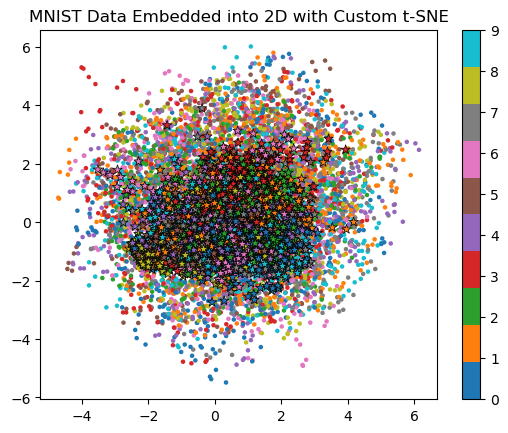

In [14]:
for idx, result in enumerate(results_array):
    # Transform new data
    custom_Y_new = custom_tsne.transform(X_train_normalized_opt1,result["custom_Y"],X_test)
    
    if result["custom_Y"].shape[1] == 2:
        # Visualization of the result
        plt.figure()
        plt.scatter(result["custom_Y"][:, 0], result["custom_Y"][:, 1], s=5, c=label_train.astype(int), cmap='tab10')
        plt.scatter(custom_Y_new[:, 0], custom_Y_new[:, 1], marker = '*', s=50, linewidths=0.5, edgecolors='k', c=label_test.astype(int), cmap='tab10')
        plt.colorbar()
        plt.title(f"MNIST Data Embedded into 2D with Custom t-SNE with {hypher_pharams_options[idx]['n_iter']} iterations, perplexity {hypher_pharams_options[idx]['perplexity']} and lr {hypher_pharams_options[idx]['learning_rate']}")
        plt.show()

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 

We used ChatGPT to help us utilize numpy vectorised functions more effieintly. It also proposed subtracting the maximum when calculating exponents, in order to avoid very large/small values.